# Importation des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [2]:
#Ce code permet de faire fonctionner tout le fichier dans VSCode et dans Google Collab sans avoir besoin de changer le code
def check_and_mount_drive():
    error = False
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        error = True
    return error

error_detected = check_and_mount_drive()


Mounted at /content/drive


# Importation des bibliothèque

In [14]:
from time import time

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
#from drive.MyDrive.RNN_sentiment_dataset.random_tweets import *

# TF IDF Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csc_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# CNN Imports
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dense, Dropout, Flatten, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


In [4]:
if error_detected == True:
    file_path = "C:/Users/titou/OneDrive/Documents/ISEN/4 eme année/NLP/Projet/data_classification_commentaires_toxiques/train.csv"
else:
    file_path = "/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv"
randomnumber = random.randint(0, 1000000)
print (randomnumber) #Prend un nombre aléatoire pour la selection des données
data = pd.read_csv(file_path).sample(n=50000, random_state=randomnumber) #On prend 10000 données aléatoires
data.head()

389839


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
116259,6d8aab8d35fb342d,"Sorry aqbout that brief hiatus, can you exploa...",0,0,0,0,0,0
113568,5f48ae4546e3363e,"Where it belongs, on the Talk Page of certain ...",0,0,0,0,0,0
140141,edebb9051c9fd860,I wasnt talking to u \n\nWhen i said who the h...,0,0,0,0,0,0
121322,891d6b977a505519,This article is simply nonsense through and th...,1,0,0,0,0,0
158390,ecf68e1ffcc30b78,Edits by 64.12.122.198\n\nSo? What's the stor...,0,0,0,0,0,0


# Préparation des données

In [8]:
# Télécharger les stopwords (si ce n'est pas déjà fait)
nltk.download('stopwords')

# Fonction améliorée pour nettoyer les commentaires
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+|www.\S+', '', text)  # Enlever les URLs
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions (@user)
    text = re.sub(r'[^a-z\s]', '', text)  # Supprimer tout sauf les lettres et espaces
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer espaces inutiles
    return text

# Appliquer le nettoyage sur la colonne 'comment_text'
data['cleaned_comment_text'] = data['comment_text'].apply(clean_text)

# Supprimer les stopwords
stop_words = set(stopwords.words('english'))
data['tokenized_comment_text'] = data['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Convertir le texte en séquences numériques
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_comment_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_comment_text'])

# Calculer la longueur maximale de commentaire pour le padding
max_length = int(data['cleaned_comment_text'].apply(lambda x: len(x.split())).median())
print(f"Longueur médiane des commentaires : {max_length}")

# Appliquer le padding sur les séquences pour qu'elles aient toutes la même longueur
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Afficher les 5 premières séquences pour voir le résultat
print(padded_sequences[:5])

print("Exemple de texte AVANT nettoyage :")
print(data['comment_text'].iloc[0])

print("\nExemple de texte APRÈS nettoyage :")
print(data['cleaned_comment_text'].iloc[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Longueur médiane des commentaires : 34
[[  248     4 21010    26    22   167   232     7  1040 31296   796     2
     16   505     2    20 24851   218 45681    13   767   385    20   187
    150  3700     4  1134   488    20  2427   267    11    81]
 [  125    11  1522    15     1    40    27     3   629    74     6    19
    331     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0]
 [    7   508   564     2   228    82     7   155    64     1   697    18
    228     7    23   564     2    13 21011   618    64   995    36     5
    343    34    38     7   324    15    37     0     0     0]
 [   13    24     8   284   711   316     4   316   310    11   137   122
     77    39    65    13  1450    31     1   112     1   128   287     8
    937  3701     0     0     0     0     0     0     0     0]
 [  147    11    17   211    22     6   614  2289     2    13   506     5
   4835     3   152   439     1   180   173

# Etude du jeu de données

Informations de base sur le dataset :
<class 'pandas.core.frame.DataFrame'>
Index: 49990 entries, 116259 to 38709
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      49990 non-null  object
 1   comment_text            49990 non-null  object
 2   toxic                   49990 non-null  int64 
 3   severe_toxic            49990 non-null  int64 
 4   obscene                 49990 non-null  int64 
 5   threat                  49990 non-null  int64 
 6   insult                  49990 non-null  int64 
 7   identity_hate           49990 non-null  int64 
 8   comment_length          49990 non-null  int64 
 9   cleaned_comment_text    49990 non-null  object
 10  tokenized_comment_text  49990 non-null  object
dtypes: int64(7), object(4)
memory usage: 4.6+ MB
None

Vérification des valeurs manquantes :
id                        0
comment_text              0
toxic                     0

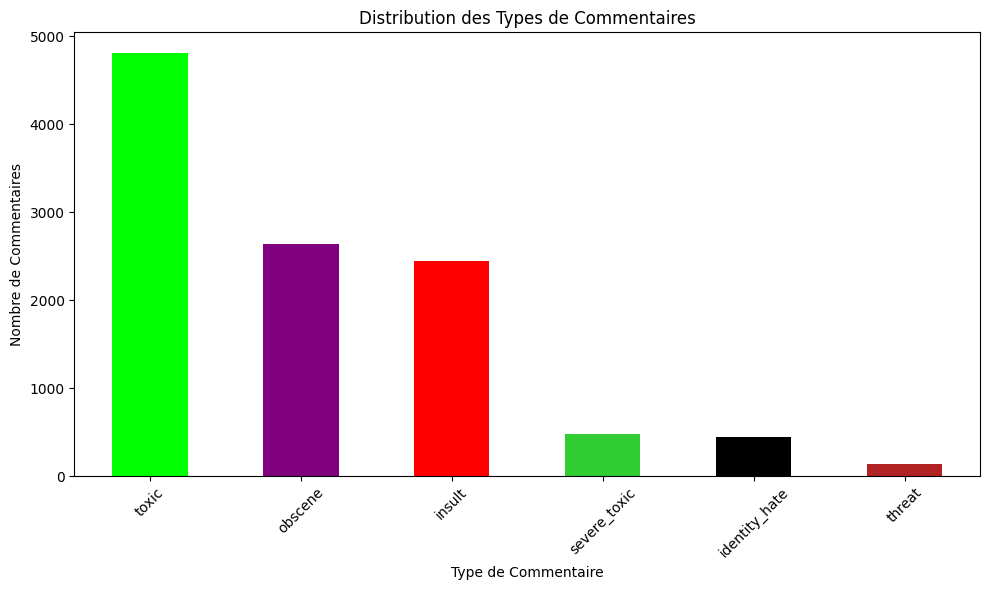

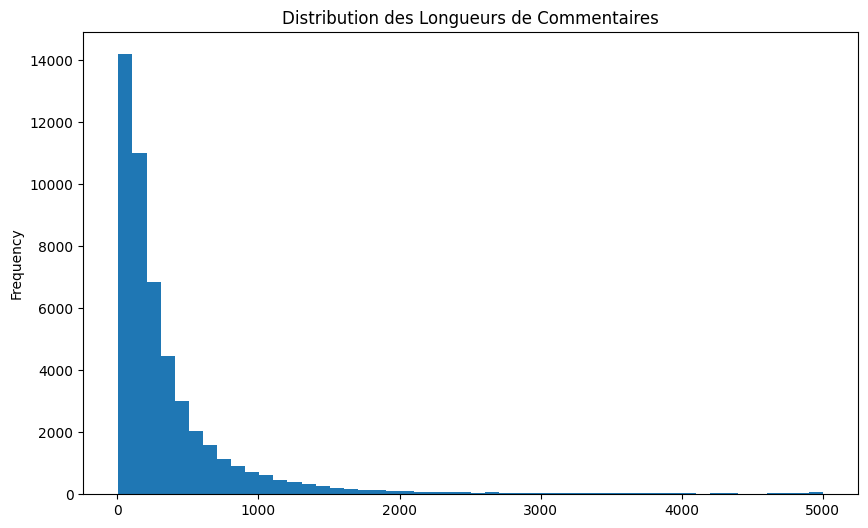

In [12]:
# Affichage des informations de base sur le dataset
print("Informations de base sur le dataset :")
print(data.info())

# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes :")
print(data.isnull().sum())

# Supprimer les lignes où le commentaire est devenu vide après nettoyage
data = data[data['cleaned_comment_text'].str.strip() != '']
print(f"\nDonnées après suppression des commentaires vides : {data.shape}\n")


# Distribution des types de commentaires
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Liste des couleurs pour chaque type de commentaire
colors = ['#00FF00', '#800080', '#FF0000', '#32CD32', '#000000', '#B22222']

# Création d'un graphique pour la distribution des types de commentaires avec des couleurs différentes
plt.figure(figsize=(10, 6))
data[target_columns].sum().sort_values(ascending=False).plot(kind='bar', color=colors)
plt.title('Distribution des Types de Commentaires')
plt.xlabel('Type de Commentaire')
plt.ylabel('Nombre de Commentaires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Affichage de la distribution des longueurs de commentaires
data['comment_length'] = data['comment_text'].apply(len)
data['comment_length'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution des Longueurs de Commentaires')
plt.show()

# Entraînement du modèle baseline

##### A utilisé beaucoup trop de ram, on va tester autre choses

In [ ]:
"""# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_columns))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))"""

'# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)\n\n# Initialize the RandomForestClassifier\nrf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Train the model\nrf_classifier.fit(X_train, y_train)\n\n# Make predictions on the test set\ny_pred = rf_classifier.predict(X_test)\n\n# Evaluate the model\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred, target_names=target_columns))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))\n\nprint("Accuracy Score:")\nprint(accuracy_score(y_test, y_pred))'

In [33]:
# Fonction pour traiter chaque chunk
def process_chunk(chunk, chunk_index):
    start_time = time()
    tweet_tokenizer = TweetTokenizer()  # Définir le tweet_tokenizer

    # Nettoyage du texte
    chunk['cleaned_comment_text'] = chunk['comment_text'].apply(clean_text)

    # Supprimer les commentaires vides après nettoyage (en maintenant les indices)
    chunk = chunk[chunk['cleaned_comment_text'].str.strip() != ""].reset_index(drop=True)

    # Tokenisation
    chunk['tokenized_comment_text'] = chunk['cleaned_comment_text'].apply(tweet_tokenizer.tokenize)

    # Suppression des stopwords
    chunk['tokenized_comment_text'] = chunk['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

    # Conversion en séquences de tokens
    sequences = tokenizer.texts_to_sequences(list(chunk['cleaned_comment_text']))  # Utilisation de `list()` pour accélérer

    # Supprimer les lignes avec NaN dans les labels et ré-aligner les indices
    chunk = chunk.dropna(subset=target_columns).reset_index(drop=True)

    # Utiliser la même longueur pour tous les chunks
    max_length = global_max_length

    # Padding
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Vérification du nombre de lignes après traitement et nettoyage
    print(f"✅ Chunk {chunk_index} traité en {time() - start_time:.2f} sec - {len(chunk)} commentaires")
    print(f"✅ Taille des séquences après padding: {padded_sequences.shape[0]}")

    return padded_sequences, chunk[target_columns].values

# Paramètres de traitement en chunks
chunk_size = 10000
padded_sequences_list = []
y_list = []

# Lecture et traitement des données en chunks
for chunk_index, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, nrows=chunk_size * 5)):
    padded_sequences_chunk, y_chunk = process_chunk(chunk, chunk_index)
    padded_sequences_list.append(padded_sequences_chunk)
    y_list.append(y_chunk)

# Concaténation des résultats finaux
padded_sequences = np.concatenate(padded_sequences_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Vérifier la taille des données
print("✅✅ Traitement terminé ! Nombre total de séquences:", padded_sequences.shape[0])
print("📊 Taille de padded_sequences:", padded_sequences.shape[0])
print("📊 Taille de y:", y.shape[0])

# Vérification de la correspondance des tailles
assert padded_sequences.shape[0] == y.shape[0], "Les tailles de X et y ne correspondent pas !"

print("🔹 Exemple final de séquences après traitement:", padded_sequences[:5])


✅ Chunk 0 traité en 3.86 sec - 9997 commentaires
✅ Taille des séquences après padding: 9997
✅ Chunk 1 traité en 4.99 sec - 9998 commentaires
✅ Taille des séquences après padding: 9998
✅ Chunk 2 traité en 3.96 sec - 10000 commentaires
✅ Taille des séquences après padding: 10000
✅ Chunk 3 traité en 3.72 sec - 10000 commentaires
✅ Taille des séquences après padding: 10000
✅ Chunk 4 traité en 4.99 sec - 9999 commentaires
✅ Taille des séquences après padding: 9999
✅✅ Traitement terminé ! Nombre total de séquences: 49994
📊 Taille de padded_sequences: 49994
📊 Taille de y: 49994
🔹 Exemple final de séquences après traitement: [[  586  4113 12431  1195    80   329    52  2092 20109    51  6888    15
     61  2840   141     7  2545    33   114  1039 14467  3134     4    45
     53   228     1   436    30     1    40    27   140    69  3293    89]
 [   54  2330    13  1407  3382    69  4567  2717    21    95    40   975
    166     0     0     0     0     0     0     0     0     0     0     0
    

In [34]:
print(f"📊 Taille de padded_sequences: {padded_sequences.shape[0]}")
print(f"📊 Taille de data[target_columns]: {data[target_columns].shape[0]}")

📊 Taille de padded_sequences: 49994
📊 Taille de data[target_columns]: 49990


# Itération de la modélisation

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6069 - loss: 0.1412
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9319 - loss: 0.0552
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8771 - loss: 0.0397
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7515 - loss: 0.0326
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6900 - loss: 0.0279
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4743 - loss: 0.0240
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4794 - loss: 0.0211
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5119 - loss: 0.0192
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5547 - loss: 0.0168
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5616 - loss: 0.0145
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report with CNN:
               precision    recall  f1-score 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


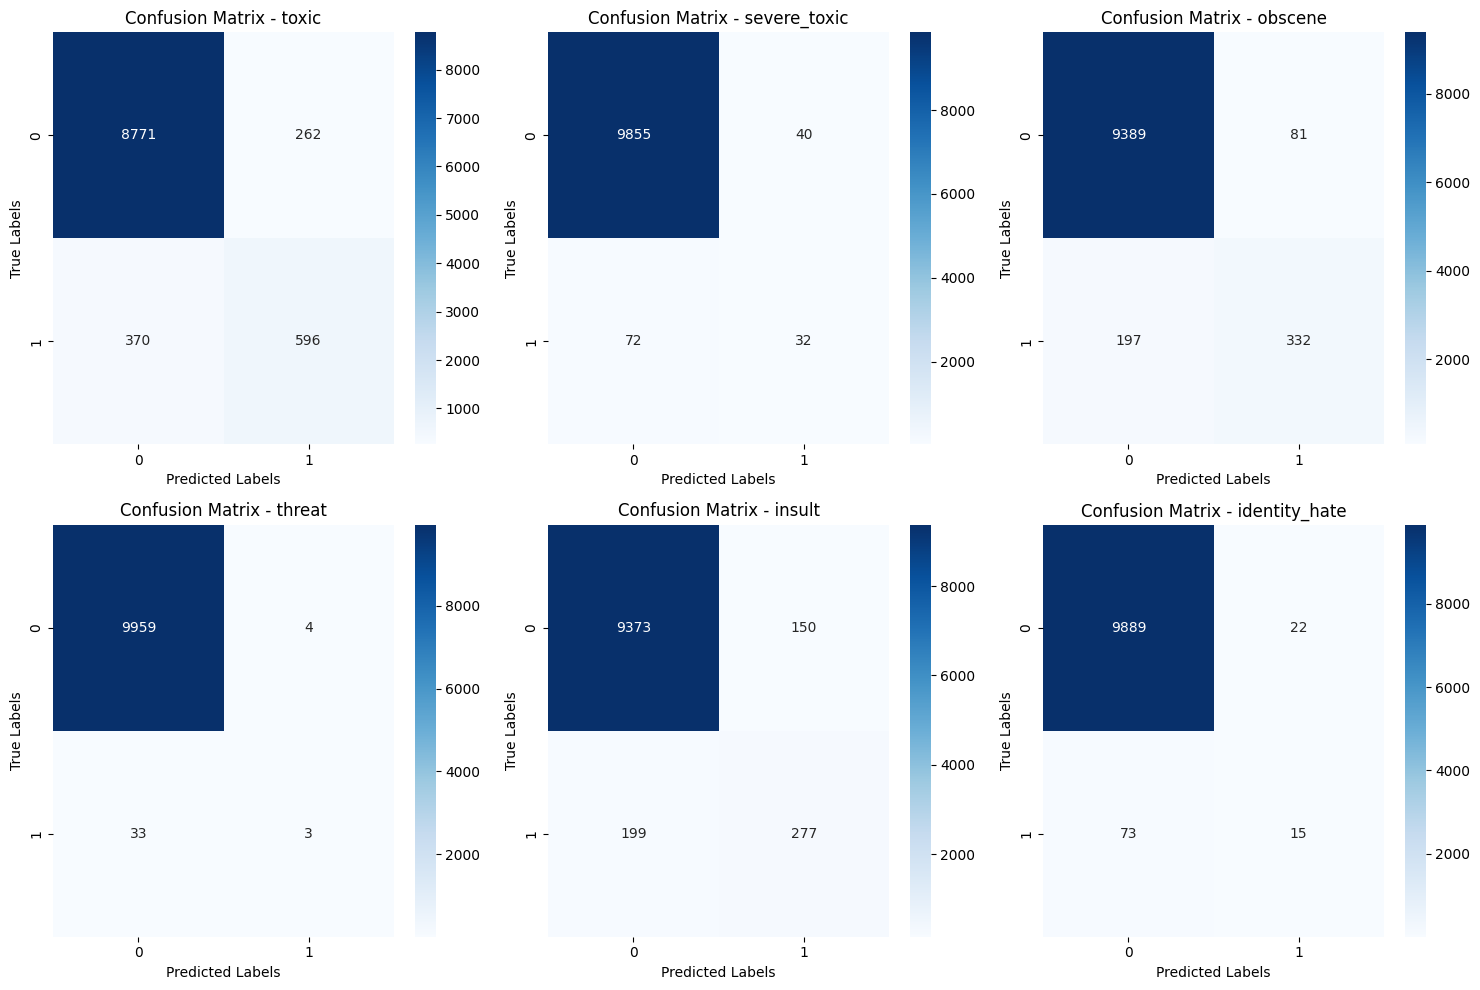

Accuracy Score with CNN:
0.8933893389338934


In [42]:
# Ajuster le Tokenizer sur ton ensemble de texte
tokenizer.fit_on_texts(data['cleaned_comment_text'])

# Obtenir la taille du vocabulaire
vocab_size = len(tokenizer.word_index) + 1  # Ajouter 1 car l'index commence à 1

# Définition du modèle CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Découper les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Matrice de confusion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes
#axes = axes.ravel() # Remove this line to keep axes as a 2D array

# Boucle pour chaque colonne (chaque type de commentaire)
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    # Accéder aux données de y_test en utilisant l'indexation NumPy
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    # Use i to index the flattened axes array
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report with CNN:
               precision    recall  f1-score   support

        toxic       0.71      0.63      0.67       208
 severe_toxic       0.50      0.11      0.17        19
      obscene       0.74      0.50      0.60       117
       threat       0.00      0.00      0.00         7
       insult       0.74      0.40      0.52       112
identity_hate       0.40      0.18      0.25        11

    micro avg       0.72      0.51      0.59       474
    macro avg       0.51      0.30      0.37       474
 weighted avg       0.70      0.51      0.58       474
  samples avg       0.06      0.05      0.05       474



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

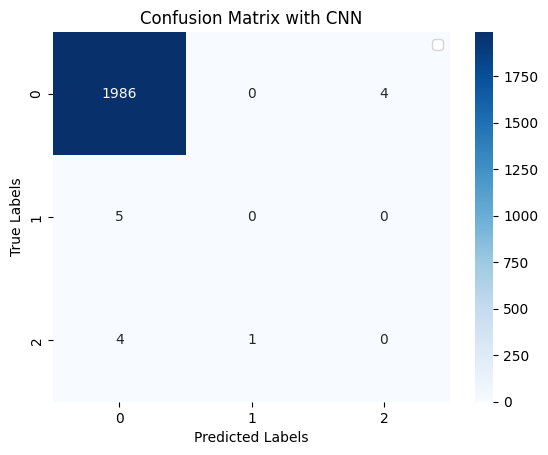

Accuracy Score with CNN:
0.8825


In [33]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred_best_binary.argmax(axis=1)), annot=True, fmt='d', cmap='Blues')

# Ajouter un titre et une légende à la matrice de confusion
plt.title('Confusion Matrix with CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.legend(['True Negative', 'False Positive', 'False Negative', 'True Positive'], loc='upper right')
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))


Shape of padded_sequences: (10000, 100)
Shape of target columns: (10000, 6)
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5186 - loss: 0.2190 - val_accuracy: 0.7050 - val_loss: 0.1634
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6800 - loss: 0.1275 - val_accuracy: 0.8005 - val_loss: 0.1422
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6931 - loss: 0.0858 - val_accuracy: 0.1435 - val_loss: 0.1435
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4761 - loss: 0.0495 - val_accuracy: 0.2510 - val_loss: 0.1708
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6026 - loss: 0.0372 - val_accuracy: 0.6875 - val_loss: 0.1979
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7159 - loss: 0.0318 - val_accuracy: 0.7860 - val_loss: 0.2015
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8441 - loss: 0.0284 - val_accuracy: 0.8170 - val_loss: 0.2308
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8655 - loss: 0.0186 - val_accuracy: 0.8240 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

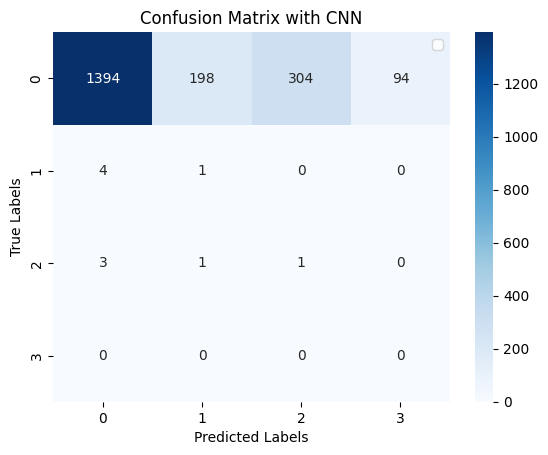

Accuracy Score with CNN:
0.847


In [34]:
# Assurez-vous que les données sont bien préparées
print(f"Shape of padded_sequences: {padded_sequences.shape}")
print(f"Shape of target columns: {data[target_columns].shape}")

# Ajuster les séquences en fonction de max_length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Assurez-vous que les tailles sont cohérentes
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Si la taille des échantillons est trop grande, sous-échantillonner (exemple ici : 30% des données)
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

# Construire un modèle CNN
model = Sequential()

# Ajouter la couche d'embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))

# Ajouter la couche convolutionnelle 1D
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Ajouter une couche de pooling
model.add(MaxPooling1D(pool_size=4))

# Aplatir les données pour les passer aux couches denses
model.add(Flatten())

# Ajouter une couche dense
model.add(Dense(128, activation='relu'))

# Ajouter la couche de sortie
model.add(Dense(len(target_columns), activation='sigmoid'))  # Sigmoid pour classification multiclasse

# Compiler le modèle
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = {i: weight for i, weight in enumerate([1.0, 5.0, 3.0, 10.0, 2.0, 10.0])}

# Entraînement du modèle
history = model.fit(
    X_train_sample,
    y_train_sample,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    # Add callbacks for more frequent testing if needed
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping for efficiency
    #     tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),  # Save the best model
    # ],
)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Évaluer le modèle
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred_best.argmax(axis=1)), annot=True, fmt='d', cmap='Blues')

# Ajouter un titre et une légende à la matrice de confusion
plt.title('Confusion Matrix with CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.legend(['True Negative', 'False Positive', 'False Negative', 'True Positive'], loc='upper right')
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))

V52455

Shape of padded_sequences: (50000, 100)
Shape of target columns: (10000, 6)
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.4511 - loss: 0.2747 - val_accuracy: 0.5615 - val_loss: 0.1350
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9314 - loss: 0.1106 - val_accuracy: 0.2155 - val_loss: 0.1243
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5750 - loss: 0.0820 - val_accuracy: 0.6865 - val_loss: 0.1288
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7840 - loss: 0.0487 - val_accuracy: 0.7040 - val_loss: 0.1511
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5395 - loss: 0.0302 - val_accuracy: 0.5870 - val_loss: 0.1650
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.6103 - loss: 0.0276 - val_accuracy: 0.7380 - val_loss: 0.1696
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.6113 - loss: 0.0251 - val_accuracy: 0.7315 - val_loss: 0.1990
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.7681 - loss: 0.0267 - val_accuracy: 0.8325 - val_los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

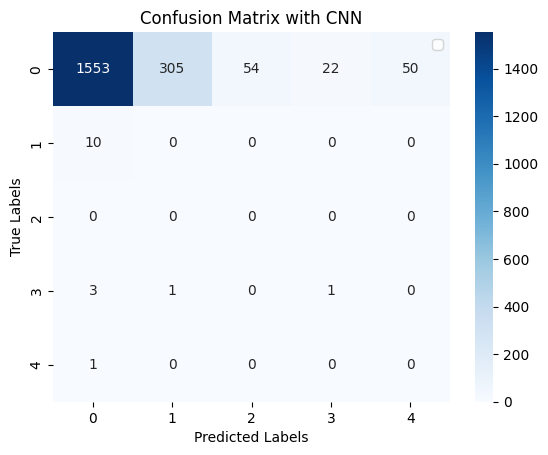

Accuracy Score with CNN:
0.837


ValueError: Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. Multilabel and multioutput targets are not supported.

In [10]:
# Assurez-vous que les données sont bien préparées
print(f"Shape of padded_sequences: {padded_sequences.shape}")
print(f"Shape of target columns: {data[target_columns].shape}")

# Ajuster les séquences en fonction de max_length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Assurez-vous que les tailles sont cohérentes
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Si la taille des échantillons est trop grande, sous-échantillonner (exemple ici : 30% des données)
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

# Construire un modèle CNN
model = Sequential()

# Ajouter la couche d'embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))

# Ajouter la couche convolutionnelle 1D
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Ajouter une couche de pooling
model.add(MaxPooling1D(pool_size=4))

# Aplatir les données pour les passer aux couches denses
model.add(Flatten())

# Ajouter une couche dense
model.add(Dense(128, activation='relu'))

# Ajouter la couche de sortie
model.add(Dense(len(target_columns), activation='sigmoid'))  # Sigmoid pour classification multiclasse

# Compiler le modèle
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

class_weights = {i: weight for i, weight in enumerate([1.0, 5.0, 3.0, 10.0, 2.0, 10.0])}

# Entraînement du modèle
history = model.fit(
    X_train_sample,
    y_train_sample,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    # Add callbacks for more frequent testing if needed
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),  # Early stopping for efficiency
    #     tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),  # Save the best model
    # ],
)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Évaluer le modèle
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test.values.argmax(axis=1), y_pred_best.argmax(axis=1)), annot=True, fmt='d', cmap='Blues')

# Ajouter un titre et une légende à la matrice de confusion
plt.title('Confusion Matrix with CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.legend(['True Negative', 'False Positive', 'False Negative', 'True Positive'], loc='upper right')
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))




from imblearn.over_sampling import RandomOverSampler

# Appliquer le suréchantillonnage sur X_train et y_train avant le split
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Utilise X_train_resampled et y_train_resampled pour l'entraînement
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights
)

from tensorflow.keras.layers import Dropout

# Ajouter une couche Dropout après la couche convolutionnelle pour éviter le surapprentissage
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))  # Ajout de Dropout à 50% après la couche de pooling

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

# Fonction de construction du modèle avec un taux d'apprentissage configurable
def build_model(learning_rate=0.01):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(target_columns), activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# GridSearch sur le taux d'apprentissage et la taille du batch
param_grid = {'learning_rate': [0.001, 0.01, 0.1], 'batch_size': [32, 64]}
grid = GridSearchCV(estimator=KerasClassifier(build_fn=build_model), param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Baisser le seuil de classification à 0.4 pour améliorer le recall
threshold = 0.4
y_pred_best_binary = (y_pred_best > threshold).astype(int)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),  # Arrêt précoce pour éviter le surapprentissage
    ModelCheckpoint('best_model.h5', save_best_only=True)  # Sauvegarde du meilleur modèle
]

# Entraînement avec les callbacks
history = model.fit(
    X_train_sample,
    y_train_sample,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Modèle LSTM
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))  # 6 classes de sortie avec activation sigmoïde

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle LSTM
class_weights = {0: 1, 1: 10}  # Exemple : ajuster les poids des classes (0 et 1)
history = model.fit(X_train, y_train, class_weight=class_weights, epochs=5, batch_size=64, validation_data=(X_test, y_test))
#history = model.fit(X_train_sample, y_train_sample, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Évaluation du modèle
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir les probabilités en prédictions binaires

# Rapport de classification
print(classification_report(y_test, y_pred, target_names=target_columns))


c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 231ms/step - accuracy: 0.3325 - loss: 0.2747 - val_accuracy: 0.9955 - val_loss: 0.1334
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 372ms/step - accuracy: 0.6813 - loss: 0.1532 - val_accuracy: 0.9955 - val_loss: 0.1324
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.7459 - loss: 0.1518 - val_accuracy: 0.9955 - val_loss: 0.1330
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - accuracy: 0.8603 - loss: 0.1498 - val_accuracy: 0.9955 - val_loss: 0.1317
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 362ms/step - accuracy: 0.8684 - loss: 0.1524 - val_accuracy: 0.9955 - val_loss: 0.1322
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
               precision    recall  f1-score   support

        toxic       0.00      0.00      0.00       182
 severe_toxic       0.00      0.00      0.00        15
      obscene       0.00      0.00      0.00        96
       threat       0.00      0.00      0.00         8
       insult       0.00      0.00

c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\titou\anaconda3\envs\mon_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(